In [1]:
#SETUP

# KEY FUNCTIONS:
# next frame = right arrow key
# previous frame = left arrow key
# frame at beginning of blue track = "b"
# frame at end of green (focal) track = "g"
# next blue track = up arrow
# previous blue track = down arrow
# next green (focal) track = "." (same button as '>')
# previous green (focal) = "," (same button as '<')
# add point (automatically adds to end of current green track) = click anywhere on picture
# remove point = 'delete/backspace' key
# add blue track to end of green track = space bar
# permanently remove blue track = "-" 

#THINGS FOR USER TO ADD:
#put them as strings - for example: '/Users/dbasili/koger_drive/long-buffalo-data/positions.npy'
video_name = 'APR18_2018_E_DJI_0011'
animal_type = 'PZ'

tracks_path = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/processed-videos/scare-clips/' + animal_type + '/' + video_name + '/localizations/tracks-complete.npy'            #file containing info about the tracks
picture_folder_path = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/raw-frames/scare-clips/*/' + video_name + '/*jpg'   #folder with the pictures
boxes_file = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/processed-videos/scare-clips/' + animal_type + '/' + video_name + '/localizations/boxes.npy'
annotated_record_file = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/processed-videos/scare-clips/' + animal_type + '/' + video_name + '/localizations/annotations.npy'
factor = 0.9                                                   #how much you want to shrink the original image
skip = 1                                                         #how many frames you want to skip
show_all_tracks = True

output_annotation_folder = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/annotations/images-and-xmls/from-tracking' 

#import
import cv2
import numpy as np
import glob
import copy
import os
import xml.etree.ElementTree as ET

In [2]:


#class for the window
class Window():
    
    #constructor
    def __init__(self, tracks_path, picture_folder_path, factor, video_name, output_folder, animal_type):
        self.tracks_path = tracks_path
        self.video_name = video_name
        self.output_folder = output_folder
        # work on a copy of the tracks info.  Don't edit the original 
        self.listoftracks = np.ndarray.tolist(copy.deepcopy(np.load(tracks_path)))
        # Focal tracks will only be sorted once
        # Use case is start from first frame and build the track to the end

        # only do something on key release
        # so only act when key press was something but now released
        self.animal_type = animal_type
        self.boxes_list = np.load(boxes_file)

        self.files = glob.glob(picture_folder_path)
        print(len(self.files))
        self.files.sort(key=lambda file: int(file.split('.')[-2].split('_')[-1]))
        self.factor = factor
        image = cv2.imread(self.files[0]) #to get size
        self.frame_shape = image.shape
        self.h = int(np.size(image,0)*factor)
        self.w = int(np.size(image,1)*factor)
        self.full_pic = np.zeros((int(self.h), self.w, 3), dtype=np.uint8)
        self.focal_box = 0
        self.framecount = 0
        self.frame_index = 0
        
        # variables for adding box
        self.adding_box = False
        self.ix = 0
        self.iy = 0
            
        self.image = cv2.imread(self.files[skip * self.framecount])
        self.num_corrections = 0
        
        self.tracks_stack = []
        
        self.boxes = []
        
        self.animal_classes = ['PZ', 'GZ', 'imp', 'buffalo', 'wbuck']
        
        
        #to help have keyboard shortcuts
    def detect_keys(self, key):
#         print(key)
#         if key != 255:
#             print(key)
        # Scroll through frames by just holding down arrow keys
        #if key == 3 or key == 83: #right key = move frame forward
        
        # k o ; l control top and left bounding box size
        if key == ord(';'):
            self.change_box_size_function(np.array([0,0,0,-1]))
        elif key == ord('k'):
            self.change_box_size_function(np.array([0,1,0,0]))
        elif key == ord('o'):
            self.change_box_size_function(np.array([1,0,0,0]))
        elif key == ord('l'):
            self.change_box_size_function(np.array([0,0,-1,0]))
        # awsd control bottom and right bounding box size
        elif key == ord('d'):
            self.change_box_size_function(np.array([0,0,0,1]))
        elif key == ord('a'):
            self.change_box_size_function(np.array([0,-1,0,0]))
        elif key == ord('w'):
            self.change_box_size_function(np.array([-1,0,0,0]))
        elif key == ord('s'):
            self.change_box_size_function(np.array([0,0,1,0]))
        elif key == ord('x'):
            self.next_box_function(1)
        elif key == ord('z'):
            self.next_box_function(-1)
        elif key == ord('.'): # . key = move focal track forward
            self.change_frame_function(1)
        elif key == ord(','): # , key = move focal track back
            self.change_frame_function(-1)
        elif key == 32: #space key = add to track
            self.save_annotation_as_xml()    
        elif key == ord('-'): #space key = add to track
            self.delete_focal_box()  
        elif key == ord('1'): #space key = add to track
            self.change_focal_animal_class(-1)  
        elif key == ord('2'): #space key = add to track
            self.change_focal_animal_class(1) 
            
    def change_focal_animal_class(self, increment):
        animal_class = self.boxes[self.focal_box]['class']
        animal_index = self.animal_classes.index(animal_class)
        animal_index += increment
        if animal_index > len(self.animal_classes) - 1:
            animal_index = 0
        if animal_index < 0:
            animal_index = len(self.animal_classes) - 1
        self.boxes[self.focal_box]['class'] = self.animal_classes[animal_index]
        self.draw_window()
        self.show_window()
            
    def get_color(self, type_string):
        if type_string == 'PZ':
            return (0, 0, 255)
        if type_string == 'GZ':
            return (255, 0, 0)
        if type_string == 'imp':
            return (226, 43, 138)
        if type_string == 'buffalo':
            return (2, 106, 253)
        if type_string == 'w_buck':
            return (255, 255, 255)
        # else
        return (0, 0, 0)
    
    def _get_boxes_center(boxes, frame_width, frame_height):
        center = np.ones((boxes.shape[0], 2))
        #need to convert from top right to bottom right origin
        center[:, 0] = (frame_height - 
                        (frame_height * (boxes[:, 0] + (boxes[:, 2] - boxes[:, 0]) / 2.0))) 
        center[:, 1] = frame_width * (boxes[:, 1] + (boxes[:, 3] - boxes[:, 1]) / 2.0)
        return center
    

    #to draw window
    def draw_window(self):
        self.drawn_image = copy.copy(self.image)
    
    
        for box_id, box_dict in enumerate(self.boxes):

            box = np.copy(box_dict['box'])
            box[::2] = box[::2] * self.drawn_image.shape[0]
            box[1::2] = box[1::2] * self.drawn_image.shape[1]
            
            if box_id == self.focal_box:
                color = (0, 255, 0)
                buffer = 5
                cv2.rectangle(self.drawn_image, (int(box[1] - buffer), int(box[0] - buffer)), (int(box[3] + buffer), int(box[2] + buffer)), color, 2)
            
            color = self.get_color(box_dict['class'])
            cv2.rectangle(self.drawn_image, (int(box[1]), int( box[0])), (int(box[3]), int( box[2])), color, 2) 
    

        
        text_size = 1
        text_spacing = 500
        text_row = 100
        font_color = (255, 255, 255)
        cv2.putText(self.drawn_image, 'current frame: %d'%self.framecount, 
                    (self.drawn_image.shape[1]-text_spacing, text_row),
                    cv2.FONT_HERSHEY_DUPLEX, text_size, font_color, 2, cv2.LINE_AA)
        cv2.putText(self.drawn_image, 'num examples: %d'%self.frame_index, 
                    (self.drawn_image.shape[1]-text_spacing*2, text_row),
                    cv2.FONT_HERSHEY_DUPLEX, text_size, font_color, 2, cv2.LINE_AA)
        for class_ind, animal_class in enumerate(self.animal_classes):
            font_color = self.get_color(animal_class)
            cv2.putText(self.drawn_image, animal_class, 
                    (self.drawn_image.shape[1]-text_spacing*(class_ind + 3), text_row),
                    cv2.FONT_HERSHEY_DUPLEX, text_size, font_color, 2, cv2.LINE_AA)
        
        
    def show_window(self, frame=None):
        if frame is None:
            frame = self.drawn_image

        frame = cv2.resize(frame, (int(frame.shape[1] * self.factor), int(frame.shape[0] * self.factor)))
        cv2.imshow('frame', frame)

    #functions for buttons
    def change_frame_function(self, increment):
        self.frame_index += increment
        if self.frame_index >= len(self.frames_list):
            self.frame_index = len(self.frames_list) - 1
        if self.frame_index < 0:
            self.frame_index = 0
        self.framecount = self.frames_list[self.frame_index]
        self.get_boxes()
        self.image = cv2.imread(self.files[skip * self.framecount])
        self.focal_box = 0
        self.draw_window()
        self.show_window()
        
    def next_box_function(self, step):
        self.focal_box = self.focal_box + step
        if self.focal_box >= len(self.boxes):
            self.focal_box = len(self.boxes) - 1
        if self.focal_box < 0:
            self.focal_box = 0 
        self.draw_window()
        self.show_window()
        
    def change_box_size_function(self, adjustment):
        adjustment = adjustment.astype(float) * 2
        adjustment[::2] = adjustment[::2] / self.frame_shape[0] 
        adjustment[1::2] = adjustment[1::2] / self.frame_shape[1]
        self.boxes[self.focal_box]['box'] += adjustment
        self.draw_window()
        self.show_window()
        
    def give_frames_to_annotate(self, frames_list):
        self.frames_list = frames_list
        self.framecount = self.frames_list[self.frame_index]
        self.image = cv2.imread(self.files[skip * self.framecount])
        self.get_boxes()
        
    def draw_rectangle(self, x, y, color):
        frame = copy.copy(self.drawn_image)
        cv2.rectangle(frame, (int(self.ix / self.factor), int(self.iy / self.factor)), 
                      (int(x / self.factor), int(y / self.factor)), color, 2)
        self.show_window(frame)
        
    def add_box(self, event, x, y, flags, params):

        if event == cv2.EVENT_LBUTTONDOWN:
            self.adding_box = True
            self.ix, self.iy = x, y
        elif event == cv2.EVENT_MOUSEMOVE:
            if self.adding_box == True:
                self.draw_rectangle(x, y, (255, 255, 255))
        elif event == cv2.EVENT_LBUTTONUP:
            self.adding_box = False
            box = [[] for _ in range(4)]
            if self.iy < y:
                box[0] = self.iy / self.frame_shape[0] / self.factor
                box[2] = y  / self.frame_shape[0] / self.factor
            else:
                box[0] = y / self.frame_shape[0] / self.factor
                box[2] = self.iy  / self.frame_shape[0] / self.factor
            if self.ix < x:
                box[1] = self.ix / self.frame_shape[1] / self.factor
                box[3] = x / self.frame_shape[1] / self.factor
            else:
                box[1] = x / self.frame_shape[1] / self.factor
                box[3] = self.ix / self.frame_shape[1] / self.factor

            box = np.array(box)
            self.boxes.append({'box': box, 'type': 'auto', 'class': animal_type})
            self.focal_box = len(self.boxes) - 1
            self.draw_window()
            self.show_window()
            
    def convert_class_to_string(self, class_int):
        if class_int == 1:
            if animal_type == 'PZ':
                return 'PZ'
            if animal_type == 'GZ':
                return 'GZ'
            else:
                return 'PZ'
        if class_int == 2:
            return 'imp'
        if class_int == 3:
            return 'buffalo'
        if class_int == 4:
            return 'wbuck'
        if class_int == 5:
            return 'eland'
        
            
            
    def get_boxes(self):
        self.boxes = []
        for track_id, track in enumerate(self.listoftracks):
            if track['first_frame'] > self.framecount:
                continue
            if track['last_frame'] < self.framecount:
                continue
            rel_frame = self.framecount - track['first_frame']

            if not np.isnan(track['pos_index'][rel_frame]):
                box = np.copy(self.boxes_list[self.framecount][int(track['pos_index'][rel_frame][0])])
                if 'class' in track.keys():
                    class_type = self.convert_class_to_string(track['class'][0])
                    self.boxes.append({'box': box, 'type': 'manual', 'class': class_type})
                else:
                    self.boxes.append({'box': box, 'type': 'manual', 'class': animal_type})
            else:
                box_size = 90
                box_size = box_size 
                center = track['track'][rel_frame] 
                box = [[] for _ in range(4)]
                box[0] = 1 - (center[0] + box_size / 2) / self.frame_shape[0]
                box[1] = (center[1] - box_size / 2) / self.frame_shape[1]
                box[2] = 1 - (center[0] - box_size / 2)  / self.frame_shape[0]
                box[3] = (center[1] + box_size / 2) / self.frame_shape[1]
                box = np.array(box)
                if 'class' in track.keys():
                    class_type = self.convert_class_to_string(track['class'][0])
                    self.boxes.append({'box': box, 'type': 'auto', 'class': class_type})
                else:
                    self.boxes.append({'box': box, 'type': 'auto', 'class': animal_type})
    
    def count_missing_boxes(self):
        max_length = 0
        for track in self.listoftracks:
            if track['last_frame'] > max_length:
                max_length = track['last_frame']
        missing_boxes_list = []
        active_tracks_list = []
        for frame in range(max_length):
            # default is no boxes are missing
            missing_boxes_list.append(0)
            active_tracks_list.append(0)
            for track in self.listoftracks:
                if track['first_frame'] <= frame:
                    if track['last_frame'] > frame:
                        rel_frame = frame - track['first_frame']
                        active_tracks_list[-1] += 1
                        if np.isnan(track['pos_index'][rel_frame]):
                            missing_boxes_list[-1] += 1
                            

        return missing_boxes_list, active_tracks_list


    def save_annotation_as_xml(self):

        frame_name = self.video_name + '-' + str(self.framecount) 
        frame_file = os.path.join(self.output_folder, frame_name + '.jpg')
        cv2.imwrite(frame_file, self.image)
        
        # record that this file is being annotated
        if not os.path.exists(annotated_record_file):
            record_file = []
        else:
            record_file = np.load(annotated_record_file)
        record_file = np.append(record_file, self.framecount)
        np.save(annotated_record_file, record_file)
        
        new_xml = ET.Element('annotation')
        folder = ET.SubElement(new_xml, 'folder')
        folder.text = 'annotated-frames'
        filename = ET.SubElement(new_xml, 'filename')
        filename.text = frame_name + '.jpg'
        image_size = ET.SubElement(new_xml, 'size')
        image_width = ET.SubElement(image_size, 'width')
        image_width.text = str(self.image.shape[1])
        image_height = ET.SubElement(image_size, 'height')
        image_height.text = str(self.image.shape[0])
        image_depth = ET.SubElement(image_size, 'depth')
        image_depth.text = str(self.image.shape[2])

        segmented = ET.SubElement(new_xml, 'segmented')
        segmented.text = '0'

        for box in self.boxes:
            animal_object = ET.SubElement(new_xml, 'object')
            #name
            animal_name = self.animal_type
#             animal_age = name[1]
            name = ET.SubElement(animal_object, 'name')
            name.text = box['class']
            #pose
            pose = ET.SubElement(animal_object, 'pose')
            pose.text = 'Unspecified'
            #truncated
            truncated = ET.SubElement(animal_object, 'truncated')
            truncated.text = '0'
            #difficult
            difficult = ET.SubElement(animal_object, 'difficult')
            difficult.text = '1'

#             polygon_list = animal.findall('polygon')
#             points = polygon_list[frame].findall('pt')
#             top_left = [(points[0].find('x').text), (points[0].find('y').text)]
#             bottom_right = [(points[2].find('x').text), (points[2].find('y').text)]

            #bndbox
            bndbox = ET.SubElement(animal_object, 'bndbox')
            xmin = ET.SubElement(bndbox, 'xmin')
            xmin.text = str(int(box['box'][1] * self.image.shape[1]))
            ymin = ET.SubElement(bndbox, 'ymin')
            ymin.text = str(int((box['box'][0]) * self.image.shape[0]))
            xmax = ET.SubElement(bndbox, 'xmax')
            xmax.text = str(int(box['box'][3] * self.image.shape[1]))
            ymax = ET.SubElement(bndbox, 'ymax')
            ymax.text = str(int((box['box'][2]) * self.image.shape[0]))

            #age
#             age = ET.SubElement(animal_object, 'age')
#             age.text = animal_age 
        if not os.path.exists(os.path.join(self.output_folder, 'annotations/')):
            os.mkdir(os.path.join(self.output_folder, 'annotations/'))
        outfile = os.path.join(self.output_folder, 'annotations/' + frame_name + str('.xml'))
        tree = ET.ElementTree(new_xml)
        tree.write(outfile)
        print('saved to ', outfile)
        self.change_frame_function(1)
    
    def delete_focal_box(self):
        if len(self.boxes) == 0:
            return
        del self.boxes[self.focal_box]
        if self.focal_box >= len(self.boxes):
            self.focal_box = len(self.boxes) - 1
        self.draw_window()
        self.show_window()

        

        
    


In [3]:
#get good track, draw image on window, set mouse to work
window = Window(tracks_path, picture_folder_path, factor, video_name, output_annotation_folder, animal_type)

window.get_boxes()
missing_boxes, active_tracks = window.count_missing_boxes()
print(len(window.boxes))

9817
10


9816
There haven't been any frames annotated from this clip


Text(0.5,1,'Sorted frame number for selected frames')

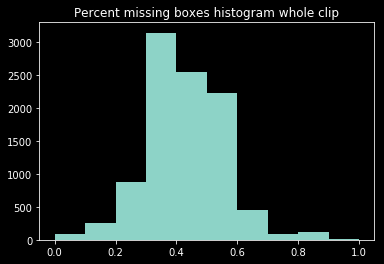

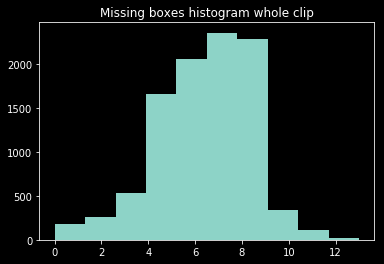

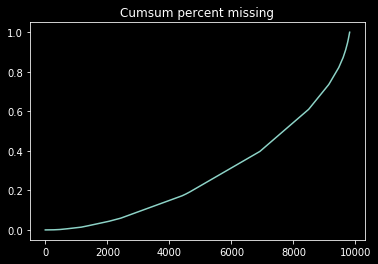

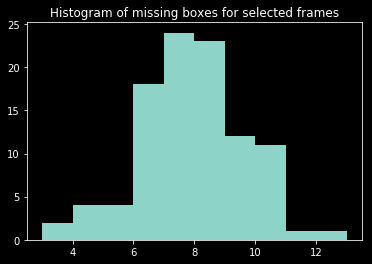

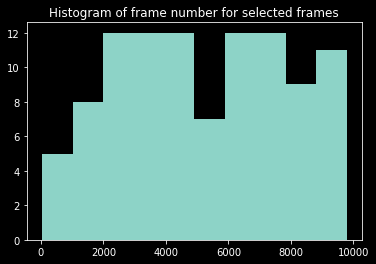

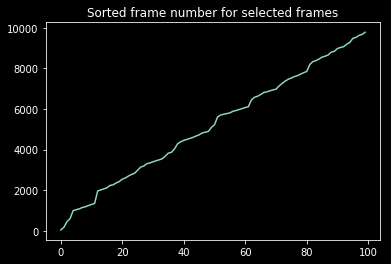

In [5]:
from matplotlib import pyplot as plt
plt.style.use('dark_background')
max_frame = len(missing_boxes)
# max_frame = 4500
print(max_frame)
missing_boxes = np.array(missing_boxes[:max_frame])
active_tracks = np.array(active_tracks[:max_frame])
percent = missing_boxes[1:] / active_tracks[1:]


plt.figure()
plt.hist(percent[:max_frame])
plt.title('Percent missing boxes histogram whole clip')

plt.figure()
plt.hist(missing_boxes[:max_frame])
plt.title('Missing boxes histogram whole clip')

percent_missing = percent ** 3 
sort_index = percent_missing.argsort()
missing_sorted = np.sort(percent_missing)

missing_sum = np.cumsum(missing_sorted)
missing_sum = missing_sum / missing_sum[-1]
plt.figure()
plt.plot(missing_sum)
plt.title('Cumsum percent missing')
# plt.plot(missing_sum / missing_sum[-1])

num_annotations = 100
frame_missing = []
new_frames_to_annotate = []
if os.path.exists(annotated_record_file):
    seen = np.load(annotated_record_file)
    print('There have already been ', len(seen), 'frames annotated from this clip')
else:
    seen = np.array([])
    print('There haven\'t been any frames annotated from this clip')
frame = 0
while frame < num_annotations:
    rand = np.random.rand()
    ind_greater = np.searchsorted(missing_sum, rand, 'right')
    ind_frame = sort_index[ind_greater]
    if ind_frame not in seen:
        frame_missing.append(missing_boxes[ind_frame+1])
        # so that you don't get frames that are too close to each other
        # buffer by 2 seconds  (60 frames)
        buffer = 30
        for i in range(ind_frame + 1 - buffer, ind_frame + 1 + buffer):
            seen = np.append(seen, i)
        new_frames_to_annotate.append(ind_frame + 1)
        frame += 1
plt.figure()
plt.hist(frame_missing)
plt.title('Histogram of missing boxes for selected frames')
plt.figure()
plt.hist(new_frames_to_annotate)
plt.title('Histogram of frame number for selected frames')
plt.figure()
plt.plot(np.sort(new_frames_to_annotate))
plt.title('Sorted frame number for selected frames')


In [6]:
#RUN

cv2.namedWindow('frame')
cv2.setMouseCallback('frame', window.add_box)

window.give_frames_to_annotate(np.sort(new_frames_to_annotate))
window.draw_window()
window.show_window()




#loop to keep image updating
while True:
#     cv2.imshow('pic0', window.full_pic)
    #stop loop if press 'x'
    key = cv2.waitKey(2) & 0xff
    window.detect_keys(key)
    if key == 27:
        break
cv2.destroyAllWindows()

saved to  /media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/annotations/images-and-xmls/from-tracking/annotations/APR18_2018_E_DJI_0011-42.xml
saved to  /media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/annotations/images-and-xmls/from-tracking/annotations/APR18_2018_E_DJI_0011-170.xml
saved to  /media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/annotations/images-and-xmls/from-tracking/annotations/APR18_2018_E_DJI_0011-445.xml
saved to  /media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/annotations/images-and-xmls/from-tracking/annotations/APR18_2018_E_DJI_0011-985.xml
saved to  /media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/annotations/images-and-xmls/from-tracking/annotations/APR18_2018_E_DJI_0011-1039.xml
saved to  /media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/annotations/images-and-xmls/from-tracking/annotations/APR18_2018_E_DJI_0011-1080.xml
saved to  /media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-trackin

In [3]:
import numpy as np
np.array([1]) / np.array([7])

array([0.14285714])

In [ ]:
len(window.listoftracks)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import copy
tracks_path = '/media/golden/72FFC6EE48B5CF39/kenya-tracking/processed_videos/APR03_2018_C_DJI_0284/localizations/tracks.npy' 

In [6]:
tracks = np.load(tracks_path)

In [9]:
starting_frame = [track['first_frame'] for track in tracks]


In [8]:
import numpy as np
x = np.ones((10,2))
y = np.ones((10,2)) * 10

In [2]:
x = 10

In [3]:
if x == 10:
    x = 5
else:
    print('here')

In [17]:
import numpy as np
x = np.array([0,0,1,1]).astype(float)
y = np.array([0,3,2,1])
print(x[::2] / 4096)
t = y[1::2] / 4000
print('t',t)
x[:2] = t
print(x)

[0.         0.00024414]
t [0.00075 0.00025]
[7.5e-04 2.5e-04 1.0e+00 1.0e+00]


In [19]:
x = [{'c': 10, 'k': 1}, {'c': 3, 'k': 2}, {'c': 5, 'k': 3}]

In [2]:
import copy

In [3]:
x_copy = copy.copy(x)

In [4]:
print(x)
print(x_copy)

[{'k': 1, 'c': 10}, {'k': 2, 'c': 3}, {'k': 3, 'c': 5}]
[{'k': 1, 'c': 10}, {'k': 2, 'c': 3}, {'k': 3, 'c': 5}]


In [5]:
def sort(item):
    return item['c']

In [6]:
x_copy.sort(key=sort)

In [7]:
print(x)
print(x_copy)

[{'k': 1, 'c': 10}, {'k': 2, 'c': 3}, {'k': 3, 'c': 5}]
[{'k': 2, 'c': 3}, {'k': 3, 'c': 5}, {'k': 1, 'c': 10}]


In [8]:
x_copy[0]['c'] = -2

In [9]:
x_copy.append({'c':-13, 'k':-2})

In [10]:
print(x)
print(x_copy)

[{'k': 1, 'c': 10}, {'k': 2, 'c': -2}, {'k': 3, 'c': 5}]
[{'k': 2, 'c': -2}, {'k': 3, 'c': 5}, {'k': 1, 'c': 10}, {'k': -2, 'c': -13}]


In [11]:
x[0]['new'] = 1000

In [18]:
print(x)
print(x_copy)

[{'k': array([ 1.,  1.]), 'c': 5}]
[{'k': 2, 'c': -2}, {'k': array([ 1.,  1.]), 'c': 5}, {'k': 1, 'new': 1000, 'c': 10}, {'k': -2, 'c': -13}]


In [13]:
del x[0]

In [14]:
print(len(x))
print(len(x_copy))

2
4


In [2]:
import numpy as np
x = np.load('/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/processed_videos/APR03_2018_C_DJI_0284/localizations/positions.npy' )

In [1]:
x = ['a', 'b', 'c']

In [5]:
x.index('c')

2

In [5]:
len(x[:-1])

9

In [16]:
y = np.load('test.npy')

In [7]:
np.arange(10)[-1:]

array([9])